**Copyright 2019 The TensorFlow Authors.**

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Create and convert a TensorFlow model
This notebook is designed to demonstrate the process of creating a TensorFlow model and converting it to use with TensorFlow Lite. The model created in this notebook is used in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) sample for [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


### SUZINEE's Dev. Environment

In [7]:
####################################################
# 210809 by SUZINEE
# CPU: Intel Core(TM) i5-8300H
# GPU: GTX 1060 (CUDA 10.2)
# Memory: RAM DDR16GB
# OS: Windows10 64-bit
import timeit
import platform
print(platform.python_version())
!python -V
#!conda search python

3.6.13


Python 3.6.13 :: Anaconda, Inc.


In [2]:
from tensorflow import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4-tf
2.1.0


In [4]:
#from keras import backend as K
#print(keras.__version__)
#K.tensorflow_backend._get_available_gpus()

In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6674552228088509068
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5077532672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8235843656940304076
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Import dependencies p62
Our first task is to import the dependencies we need. Run the following cell to do so:

In [10]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Numpy is a math library
import numpy as np
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# math is Python's math library
import math

## Generate data p65
Deep learning networks learn to model patterns in underlying data. In this notebook, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.

In a real world application, if you needed the sine of `x`, you could just calculate it directly. However, by training a model to do this, we can demonstrate the basic principles of machine learning.

In the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) sample for [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers/overview), we'll use this model to control LEDs that light up in a sequence.

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph:

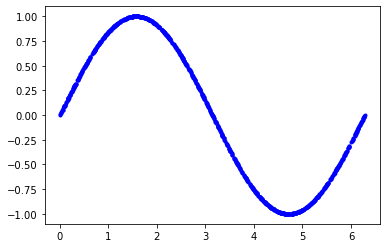

In [11]:
# We'll generate this many sample datapoints
SAMPLES = 1000

# Set a "seed" value, so we get the same random numbers each time we run this
# notebook
np.random.seed(1337)

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

## Add some noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

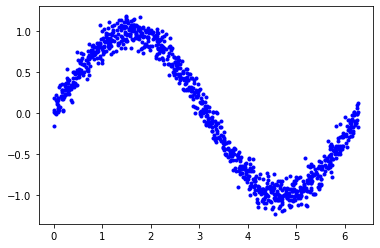

In [12]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

## Split our data p69
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

To ensure we have data to use for evaluation, we'll set some aside before we begin training. We'll reserve 20% of our data for validation, and another 20% for testing. The remaining 60% will be used to train the model. This is a typical split used when training models.

The following code will split our data and then plot each set as a different color:


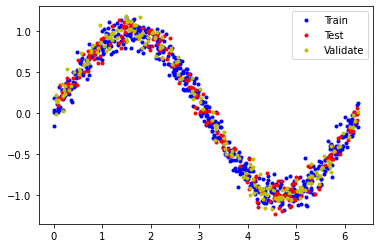

In [13]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Design a model p71
We're going to build a model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_.

To achieve this, we're going to create a simple neural network. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 16 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [8]:
# We'll use Keras to create a simple model architecture
from tensorflow.keras import layers

t_start = timeit.default_timer()
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Summary
model_1.summary()
t_end = timeit.default_timer()
print("소요시간 = %f[ms]" %((t_end-t_start)*1000))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
소요시간 = 289.975200[ms]


## Train the model p76
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 1000 _epochs_, with 16 pieces of data in each _batch_. We also pass in some data to use for _validation_. As you will see when you run the cell, training can take a while to complete:



In [14]:
t_start = timeit.default_timer()

#Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16,
                    validation_data=(x_validate, y_validate))

t_end = timeit.default_timer()
print("소요시간 = %f[ms]" %((t_end-t_start)*1000))


Train on 600 samples, validate on 200 samples
Epoch 1/1000
600/600 [==============================] - 1s 964us/sample - loss: 0.3968 - mae: 0.5485 - val_loss: 0.4243 - val_mae: 0.5596
Epoch 2/1000
600/600 [==============================] - 0s 184us/sample - loss: 0.3423 - mae: 0.5061 - val_loss: 0.3703 - val_mae: 0.5252
Epoch 3/1000
600/600 [==============================] - 0s 176us/sample - loss: 0.2995 - mae: 0.4757 - val_loss: 0.3275 - val_mae: 0.5035
Epoch 4/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.2662 - mae: 0.4500 - val_loss: 0.2896 - val_mae: 0.4739
Epoch 5/1000
600/600 [==============================] - 0s 181us/sample - loss: 0.2415 - mae: 0.4310 - val_loss: 0.2617 - val_mae: 0.4514
Epoch 6/1000
600/600 [==============================] - 0s 177us/sample - loss: 0.2185 - mae: 0.4103 - val_loss: 0.2480 - val_mae: 0.4425
Epoch 7/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.2062 - mae: 0.4013 - val_loss: 0.2174 - val_

Epoch 60/1000
600/600 [==============================] - 0s 176us/sample - loss: 0.1406 - mae: 0.3052 - val_loss: 0.1374 - val_mae: 0.3038
Epoch 61/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.1406 - mae: 0.3050 - val_loss: 0.1382 - val_mae: 0.3028
Epoch 62/1000
600/600 [==============================] - 0s 163us/sample - loss: 0.1413 - mae: 0.3022 - val_loss: 0.1412 - val_mae: 0.3096
Epoch 63/1000
600/600 [==============================] - 0s 169us/sample - loss: 0.1401 - mae: 0.3019 - val_loss: 0.1350 - val_mae: 0.3025
Epoch 64/1000
600/600 [==============================] - 0s 177us/sample - loss: 0.1392 - mae: 0.3025 - val_loss: 0.1344 - val_mae: 0.3017
Epoch 65/1000
600/600 [==============================] - 0s 162us/sample - loss: 0.1396 - mae: 0.3019 - val_loss: 0.1348 - val_mae: 0.3000
Epoch 66/1000
600/600 [==============================] - 0s 152us/sample - loss: 0.1370 - mae: 0.2972 - val_loss: 0.1487 - val_mae: 0.3153
Epoch 67/1000
600/600 [====

Epoch 119/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.1211 - mae: 0.2801 - val_loss: 0.1153 - val_mae: 0.2797
Epoch 120/1000
600/600 [==============================] - 0s 165us/sample - loss: 0.1209 - mae: 0.2805 - val_loss: 0.1172 - val_mae: 0.2818
Epoch 121/1000
600/600 [==============================] - 0s 168us/sample - loss: 0.1197 - mae: 0.2794 - val_loss: 0.1238 - val_mae: 0.2897
Epoch 122/1000
600/600 [==============================] - 0s 172us/sample - loss: 0.1190 - mae: 0.2796 - val_loss: 0.1158 - val_mae: 0.2805
Epoch 123/1000
600/600 [==============================] - 0s 150us/sample - loss: 0.1194 - mae: 0.2798 - val_loss: 0.1133 - val_mae: 0.2771
Epoch 124/1000
600/600 [==============================] - 0s 161us/sample - loss: 0.1197 - mae: 0.2793 - val_loss: 0.1130 - val_mae: 0.2757
Epoch 125/1000
600/600 [==============================] - 0s 163us/sample - loss: 0.1197 - mae: 0.2788 - val_loss: 0.1247 - val_mae: 0.2884
Epoch 126/1000
600/6

600/600 [==============================] - 0s 166us/sample - loss: 0.1067 - mae: 0.2640 - val_loss: 0.0993 - val_mae: 0.2584
Epoch 178/1000
600/600 [==============================] - 0s 161us/sample - loss: 0.1061 - mae: 0.2621 - val_loss: 0.1001 - val_mae: 0.2605
Epoch 179/1000
600/600 [==============================] - 0s 161us/sample - loss: 0.1040 - mae: 0.2607 - val_loss: 0.0983 - val_mae: 0.2562
Epoch 180/1000
600/600 [==============================] - 0s 154us/sample - loss: 0.1036 - mae: 0.2611 - val_loss: 0.0980 - val_mae: 0.2551
Epoch 181/1000
600/600 [==============================] - 0s 153us/sample - loss: 0.1060 - mae: 0.2629 - val_loss: 0.0983 - val_mae: 0.2564
Epoch 182/1000
600/600 [==============================] - 0s 155us/sample - loss: 0.1047 - mae: 0.2600 - val_loss: 0.0983 - val_mae: 0.2572
Epoch 183/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.1050 - mae: 0.2621 - val_loss: 0.0997 - val_mae: 0.2591
Epoch 184/1000
600/600 [===========

600/600 [==============================] - 0s 160us/sample - loss: 0.0927 - mae: 0.2446 - val_loss: 0.0929 - val_mae: 0.2519
Epoch 236/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0934 - mae: 0.2471 - val_loss: 0.0868 - val_mae: 0.2416
Epoch 237/1000
600/600 [==============================] - 0s 159us/sample - loss: 0.0933 - mae: 0.2465 - val_loss: 0.0864 - val_mae: 0.2404
Epoch 238/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.0920 - mae: 0.2432 - val_loss: 0.0888 - val_mae: 0.2463
Epoch 239/1000
600/600 [==============================] - 0s 155us/sample - loss: 0.0937 - mae: 0.2462 - val_loss: 0.0880 - val_mae: 0.2447
Epoch 240/1000
600/600 [==============================] - 0s 155us/sample - loss: 0.0927 - mae: 0.2443 - val_loss: 0.0910 - val_mae: 0.2468
Epoch 241/1000
600/600 [==============================] - 0s 165us/sample - loss: 0.0918 - mae: 0.2450 - val_loss: 0.0882 - val_mae: 0.2356
Epoch 242/1000
600/600 [===========

600/600 [==============================] - 0s 166us/sample - loss: 0.0819 - mae: 0.2290 - val_loss: 0.0808 - val_mae: 0.2309
Epoch 294/1000
600/600 [==============================] - 0s 159us/sample - loss: 0.0821 - mae: 0.2287 - val_loss: 0.0761 - val_mae: 0.2253
Epoch 295/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0835 - mae: 0.2326 - val_loss: 0.0757 - val_mae: 0.2231
Epoch 296/1000
600/600 [==============================] - 0s 156us/sample - loss: 0.0824 - mae: 0.2300 - val_loss: 0.0784 - val_mae: 0.2288
Epoch 297/1000
600/600 [==============================] - 0s 161us/sample - loss: 0.0822 - mae: 0.2299 - val_loss: 0.0748 - val_mae: 0.2223
Epoch 298/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0805 - mae: 0.2283 - val_loss: 0.0736 - val_mae: 0.2190
Epoch 299/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0823 - mae: 0.2276 - val_loss: 0.0772 - val_mae: 0.2273
Epoch 300/1000
600/600 [===========

600/600 [==============================] - 0s 168us/sample - loss: 0.0725 - mae: 0.2157 - val_loss: 0.0663 - val_mae: 0.2085
Epoch 352/1000
600/600 [==============================] - 0s 165us/sample - loss: 0.0721 - mae: 0.2136 - val_loss: 0.0675 - val_mae: 0.2093
Epoch 353/1000
600/600 [==============================] - 0s 156us/sample - loss: 0.0729 - mae: 0.2151 - val_loss: 0.0661 - val_mae: 0.2070
Epoch 354/1000
600/600 [==============================] - 0s 165us/sample - loss: 0.0713 - mae: 0.2121 - val_loss: 0.0670 - val_mae: 0.2104
Epoch 355/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0717 - mae: 0.2127 - val_loss: 0.0745 - val_mae: 0.2210
Epoch 356/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.0721 - mae: 0.2133 - val_loss: 0.0685 - val_mae: 0.2121
Epoch 357/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.0722 - mae: 0.2143 - val_loss: 0.0642 - val_mae: 0.2037
Epoch 358/1000
600/600 [===========

600/600 [==============================] - 0s 177us/sample - loss: 0.0642 - mae: 0.1997 - val_loss: 0.0606 - val_mae: 0.1973
Epoch 410/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0646 - mae: 0.2015 - val_loss: 0.0642 - val_mae: 0.2029
Epoch 411/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.0635 - mae: 0.2022 - val_loss: 0.0563 - val_mae: 0.1885
Epoch 412/1000
600/600 [==============================] - 0s 163us/sample - loss: 0.0640 - mae: 0.1990 - val_loss: 0.0643 - val_mae: 0.2047
Epoch 413/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0629 - mae: 0.2021 - val_loss: 0.0560 - val_mae: 0.1868
Epoch 414/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.0637 - mae: 0.2005 - val_loss: 0.0611 - val_mae: 0.2003
Epoch 415/1000
600/600 [==============================] - 0s 181us/sample - loss: 0.0630 - mae: 0.1981 - val_loss: 0.0609 - val_mae: 0.2002
Epoch 416/1000
600/600 [===========

600/600 [==============================] - 0s 168us/sample - loss: 0.0572 - mae: 0.1886 - val_loss: 0.0519 - val_mae: 0.1815
Epoch 468/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0574 - mae: 0.1898 - val_loss: 0.0545 - val_mae: 0.1868
Epoch 469/1000
600/600 [==============================] - 0s 158us/sample - loss: 0.0562 - mae: 0.1868 - val_loss: 0.0559 - val_mae: 0.1908
Epoch 470/1000
600/600 [==============================] - 0s 160us/sample - loss: 0.0564 - mae: 0.1880 - val_loss: 0.0513 - val_mae: 0.1835
Epoch 471/1000
600/600 [==============================] - 0s 156us/sample - loss: 0.0571 - mae: 0.1898 - val_loss: 0.0498 - val_mae: 0.1779
Epoch 472/1000
600/600 [==============================] - 0s 188us/sample - loss: 0.0553 - mae: 0.1859 - val_loss: 0.0502 - val_mae: 0.1800
Epoch 473/1000
600/600 [==============================] - 0s 161us/sample - loss: 0.0558 - mae: 0.1873 - val_loss: 0.0502 - val_mae: 0.1795
Epoch 474/1000
600/600 [===========

600/600 [==============================] - 0s 210us/sample - loss: 0.0507 - mae: 0.1772 - val_loss: 0.0449 - val_mae: 0.1675
Epoch 526/1000
600/600 [==============================] - 0s 206us/sample - loss: 0.0514 - mae: 0.1775 - val_loss: 0.0506 - val_mae: 0.1808
Epoch 527/1000
600/600 [==============================] - 0s 205us/sample - loss: 0.0500 - mae: 0.1766 - val_loss: 0.0453 - val_mae: 0.1704
Epoch 528/1000
600/600 [==============================] - 0s 199us/sample - loss: 0.0506 - mae: 0.1767 - val_loss: 0.0449 - val_mae: 0.1696
Epoch 529/1000
600/600 [==============================] - 0s 210us/sample - loss: 0.0508 - mae: 0.1779 - val_loss: 0.0440 - val_mae: 0.1622
Epoch 530/1000
600/600 [==============================] - 0s 251us/sample - loss: 0.0503 - mae: 0.1767 - val_loss: 0.0430 - val_mae: 0.1623
Epoch 531/1000
600/600 [==============================] - 0s 270us/sample - loss: 0.0502 - mae: 0.1771 - val_loss: 0.0435 - val_mae: 0.1636
Epoch 532/1000
600/600 [===========

600/600 [==============================] - 0s 178us/sample - loss: 0.0452 - mae: 0.1687 - val_loss: 0.0385 - val_mae: 0.1555
Epoch 584/1000
600/600 [==============================] - 0s 176us/sample - loss: 0.0453 - mae: 0.1677 - val_loss: 0.0391 - val_mae: 0.1576
Epoch 585/1000
600/600 [==============================] - 0s 180us/sample - loss: 0.0441 - mae: 0.1654 - val_loss: 0.0384 - val_mae: 0.1555
Epoch 586/1000
600/600 [==============================] - 0s 163us/sample - loss: 0.0450 - mae: 0.1678 - val_loss: 0.0384 - val_mae: 0.1554
Epoch 587/1000
600/600 [==============================] - 0s 176us/sample - loss: 0.0446 - mae: 0.1646 - val_loss: 0.0416 - val_mae: 0.1648
Epoch 588/1000
600/600 [==============================] - 0s 171us/sample - loss: 0.0455 - mae: 0.1678 - val_loss: 0.0385 - val_mae: 0.1564
Epoch 589/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0448 - mae: 0.1670 - val_loss: 0.0385 - val_mae: 0.1566
Epoch 590/1000
600/600 [===========

600/600 [==============================] - 0s 180us/sample - loss: 0.0409 - mae: 0.1579 - val_loss: 0.0358 - val_mae: 0.1520
Epoch 642/1000
600/600 [==============================] - 0s 177us/sample - loss: 0.0406 - mae: 0.1577 - val_loss: 0.0350 - val_mae: 0.1427
Epoch 643/1000
600/600 [==============================] - 0s 184us/sample - loss: 0.0408 - mae: 0.1588 - val_loss: 0.0366 - val_mae: 0.1540
Epoch 644/1000
600/600 [==============================] - 0s 173us/sample - loss: 0.0401 - mae: 0.1574 - val_loss: 0.0374 - val_mae: 0.1566
Epoch 645/1000
600/600 [==============================] - 0s 181us/sample - loss: 0.0402 - mae: 0.1588 - val_loss: 0.0336 - val_mae: 0.1446
Epoch 646/1000
600/600 [==============================] - 0s 175us/sample - loss: 0.0401 - mae: 0.1557 - val_loss: 0.0378 - val_mae: 0.1585
Epoch 647/1000
600/600 [==============================] - 0s 168us/sample - loss: 0.0400 - mae: 0.1562 - val_loss: 0.0345 - val_mae: 0.1493
Epoch 648/1000
600/600 [===========

600/600 [==============================] - 0s 176us/sample - loss: 0.0365 - mae: 0.1500 - val_loss: 0.0303 - val_mae: 0.1357
Epoch 700/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0367 - mae: 0.1502 - val_loss: 0.0299 - val_mae: 0.1328
Epoch 701/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0374 - mae: 0.1497 - val_loss: 0.0343 - val_mae: 0.1500
Epoch 702/1000
600/600 [==============================] - 0s 173us/sample - loss: 0.0363 - mae: 0.1485 - val_loss: 0.0350 - val_mae: 0.1521
Epoch 703/1000
600/600 [==============================] - 0s 168us/sample - loss: 0.0365 - mae: 0.1488 - val_loss: 0.0301 - val_mae: 0.1368
Epoch 704/1000
600/600 [==============================] - 0s 172us/sample - loss: 0.0364 - mae: 0.1495 - val_loss: 0.0369 - val_mae: 0.1555
Epoch 705/1000
600/600 [==============================] - 0s 168us/sample - loss: 0.0365 - mae: 0.1492 - val_loss: 0.0306 - val_mae: 0.1403
Epoch 706/1000
600/600 [===========

600/600 [==============================] - 0s 176us/sample - loss: 0.0336 - mae: 0.1425 - val_loss: 0.0284 - val_mae: 0.1256
Epoch 758/1000
600/600 [==============================] - 0s 195us/sample - loss: 0.0331 - mae: 0.1403 - val_loss: 0.0394 - val_mae: 0.1601
Epoch 759/1000
600/600 [==============================] - 0s 179us/sample - loss: 0.0336 - mae: 0.1411 - val_loss: 0.0273 - val_mae: 0.1311
Epoch 760/1000
600/600 [==============================] - 0s 181us/sample - loss: 0.0335 - mae: 0.1423 - val_loss: 0.0339 - val_mae: 0.1495
Epoch 761/1000
600/600 [==============================] - 0s 165us/sample - loss: 0.0329 - mae: 0.1431 - val_loss: 0.0302 - val_mae: 0.1425
Epoch 762/1000
600/600 [==============================] - 0s 163us/sample - loss: 0.0329 - mae: 0.1430 - val_loss: 0.0292 - val_mae: 0.1387
Epoch 763/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0332 - mae: 0.1427 - val_loss: 0.0300 - val_mae: 0.1314
Epoch 764/1000
600/600 [===========

600/600 [==============================] - 0s 165us/sample - loss: 0.0305 - mae: 0.1363 - val_loss: 0.0270 - val_mae: 0.1253
Epoch 816/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0306 - mae: 0.1348 - val_loss: 0.0242 - val_mae: 0.1230
Epoch 817/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0301 - mae: 0.1345 - val_loss: 0.0278 - val_mae: 0.1379
Epoch 818/1000
600/600 [==============================] - 0s 173us/sample - loss: 0.0306 - mae: 0.1369 - val_loss: 0.0243 - val_mae: 0.1184
Epoch 819/1000
600/600 [==============================] - 0s 163us/sample - loss: 0.0299 - mae: 0.1344 - val_loss: 0.0274 - val_mae: 0.1285
Epoch 820/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0307 - mae: 0.1369 - val_loss: 0.0251 - val_mae: 0.1246
Epoch 821/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0300 - mae: 0.1347 - val_loss: 0.0241 - val_mae: 0.1212
Epoch 822/1000
600/600 [===========

600/600 [==============================] - 0s 168us/sample - loss: 0.0279 - mae: 0.1301 - val_loss: 0.0224 - val_mae: 0.1133
Epoch 874/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0283 - mae: 0.1293 - val_loss: 0.0270 - val_mae: 0.1329
Epoch 875/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0283 - mae: 0.1303 - val_loss: 0.0257 - val_mae: 0.1305
Epoch 876/1000
600/600 [==============================] - 0s 178us/sample - loss: 0.0276 - mae: 0.1291 - val_loss: 0.0219 - val_mae: 0.1167
Epoch 877/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0270 - mae: 0.1275 - val_loss: 0.0282 - val_mae: 0.1359
Epoch 878/1000
600/600 [==============================] - 0s 180us/sample - loss: 0.0282 - mae: 0.1308 - val_loss: 0.0220 - val_mae: 0.1159
Epoch 879/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.0282 - mae: 0.1297 - val_loss: 0.0312 - val_mae: 0.1428
Epoch 880/1000
600/600 [===========

600/600 [==============================] - 0s 174us/sample - loss: 0.0257 - mae: 0.1252 - val_loss: 0.0231 - val_mae: 0.1231
Epoch 932/1000
600/600 [==============================] - 0s 175us/sample - loss: 0.0260 - mae: 0.1250 - val_loss: 0.0213 - val_mae: 0.1178
Epoch 933/1000
600/600 [==============================] - 0s 173us/sample - loss: 0.0252 - mae: 0.1229 - val_loss: 0.0203 - val_mae: 0.1129
Epoch 934/1000
600/600 [==============================] - 0s 168us/sample - loss: 0.0260 - mae: 0.1253 - val_loss: 0.0202 - val_mae: 0.1102
Epoch 935/1000
600/600 [==============================] - 0s 177us/sample - loss: 0.0255 - mae: 0.1248 - val_loss: 0.0218 - val_mae: 0.1195
Epoch 936/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0252 - mae: 0.1230 - val_loss: 0.0310 - val_mae: 0.1413
Epoch 937/1000
600/600 [==============================] - 0s 165us/sample - loss: 0.0257 - mae: 0.1248 - val_loss: 0.0207 - val_mae: 0.1076
Epoch 938/1000
600/600 [===========

600/600 [==============================] - 0s 170us/sample - loss: 0.0244 - mae: 0.1202 - val_loss: 0.0211 - val_mae: 0.1178
Epoch 990/1000
600/600 [==============================] - 0s 173us/sample - loss: 0.0238 - mae: 0.1201 - val_loss: 0.0241 - val_mae: 0.1251
Epoch 991/1000
600/600 [==============================] - 0s 170us/sample - loss: 0.0247 - mae: 0.1234 - val_loss: 0.0195 - val_mae: 0.1123
Epoch 992/1000
600/600 [==============================] - 0s 184us/sample - loss: 0.0250 - mae: 0.1227 - val_loss: 0.0211 - val_mae: 0.1131
Epoch 993/1000
600/600 [==============================] - 0s 193us/sample - loss: 0.0235 - mae: 0.1188 - val_loss: 0.0371 - val_mae: 0.1532
Epoch 994/1000
600/600 [==============================] - 0s 182us/sample - loss: 0.0238 - mae: 0.1195 - val_loss: 0.0199 - val_mae: 0.1135
Epoch 995/1000
600/600 [==============================] - 0s 174us/sample - loss: 0.0243 - mae: 0.1207 - val_loss: 0.0284 - val_mae: 0.1355
Epoch 996/1000
600/600 [===========

- loss

    목적: 네트워크 평가

    손실 함수의 출력 값

    양의 숫자로 표현되는 평균 제곱 오차를 사용

    일반적으로 손실 값이 작을 수록 좋다.

    첫 번째와 마지막 에폭을 비교할 때 네트워크의 손실은 ~0.39에서 ~0.02로 줄어 훈련 중 명확하게 개선됐다.

- mae

    훈련 데이터의 평균 절대 오차

    네트워크 예측과 훈련 데이터 예상 값 사이의 평균 차이를 나타낸다.

    최초 오류는 매우크다. 훈련되지 않은 네트워크를 기반으로 하기 때문이다.

    네트워크의 예측값은 평균 ~0.55까지 떨어져 있다.

    그러나 훈련 후에도 평균 절대 오차는 ~0.11이다. 이는 매우 큰 수이다. 이것은 네트워크 예측이 평균 ~0.11 만큼 벗어났음을 의미한다.

- val_loss

    검증 데이터에 대한 손실 함수 출력

    마지막 에폭에서 훈련 손실(~0.0237)은 검증 손실(0.0216)보다 크다.

- val_mae

    검증 데이터의 평균 절대 오차

    ~0.1188 값으로, 훈련 데이터셋의 평균 절대 오차 ~0.1194보다 작다.

## Check the training metrics
During training, the model's performance is constantly being measured against both our training data and the validation data that we set aside earlier. Training produces a log of data that tells us how the model's performance changed over the course of the training process.

The following cells will display some of that data in a graphical form:

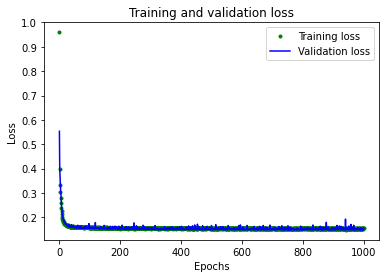

In [8]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Look closer at the data
The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!

Our goal is to stop training when either the model is no longer improving, or when the _training loss_ is less than the _validation loss_, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

To make the flatter part of the graph more readable, let's skip the first 50 epochs:

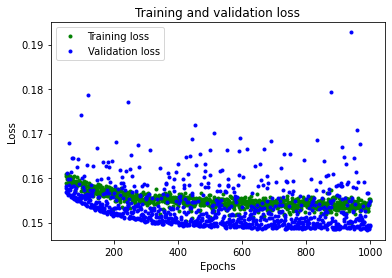

In [9]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Further metrics
From the plot, we can see that loss continues to reduce until around 600 epochs, at which point it is mostly stable. This means that there's no need to train our network beyond 600 epochs.

However, we can also see that the lowest loss value is still around 0.155. This means that our network's predictions are off by an average of ~15%. In addition, the validation loss values jump around a lot, and is sometimes even higher.

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the _mean absolute error_, which is another way of measuring how far the network's predictions are from the actual numbers:


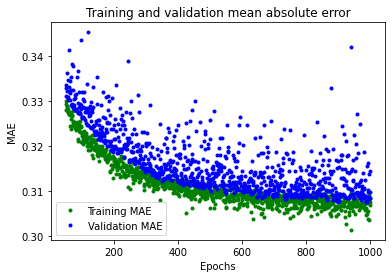

In [10]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of _mean absolute error_ tells another story. We can see that training data shows consistently lower error than validation data, which means that the network may have _overfit_, or learned the training data so rigidly that it can't make effective predictions about new data.

In addition, the mean absolute error values are quite high, ~0.305 at best, which means some of the model's predictions are at least 30% off. A 30% error means we are very far from accurately modelling the sine wave function.

To get more insight into what is happening, we can plot our network's predictions for the training data against the expected values:

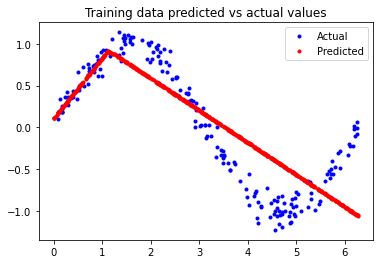

In [11]:
# Use the model to make predictions from our validation data
predictions = model_1.predict(x_train)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Oh dear! The graph makes it clear that our network has learned to approximate the sine function in a very limited way. From `0 <= x <= 1.1` the line mostly fits, but for the rest of our `x` values it is a rough approximation at best.

The rigidity of this fit suggests that the model does not have enough capacity to learn the full complexity of the sine wave function, so it's only able to approximate it in an overly simplistic way. By making our model bigger, we should be able to improve its performance.

## Change our model p84
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with an additional layer of 16 neurons in the middle:

In [15]:

model_2 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model_2.add(layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model_2.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

We'll now train the new model. To save time, we'll train for only 600 epochs:

In [16]:
t_start = timeit.default_timer()
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
                    validation_data=(x_validate, y_validate))
t_end = timeit.default_timer()
print("소요시간 = %f[ms]" %((t_end-t_start)*1000))

Train on 600 samples, validate on 200 samples
Epoch 1/600
600/600 [==============================] - 0s 729us/sample - loss: 0.7376 - mae: 0.7380 - val_loss: 0.5372 - val_mae: 0.6587
Epoch 2/600
600/600 [==============================] - 0s 191us/sample - loss: 0.4190 - mae: 0.5637 - val_loss: 0.4561 - val_mae: 0.5903
Epoch 3/600
600/600 [==============================] - 0s 189us/sample - loss: 0.3672 - mae: 0.5248 - val_loss: 0.4040 - val_mae: 0.5598
Epoch 4/600
600/600 [==============================] - 0s 182us/sample - loss: 0.3194 - mae: 0.4897 - val_loss: 0.3373 - val_mae: 0.4992
Epoch 5/600
600/600 [==============================] - 0s 192us/sample - loss: 0.2679 - mae: 0.4479 - val_loss: 0.2771 - val_mae: 0.4548
Epoch 6/600
600/600 [==============================] - 0s 176us/sample - loss: 0.2267 - mae: 0.4145 - val_loss: 0.2551 - val_mae: 0.4466
Epoch 7/600
600/600 [==============================] - 0s 176us/sample - loss: 0.1954 - mae: 0.3863 - val_loss: 0.1998 - val_mae: 0.

600/600 [==============================] - 0s 170us/sample - loss: 0.0439 - mae: 0.1527 - val_loss: 0.0545 - val_mae: 0.1816
Epoch 61/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0450 - mae: 0.1562 - val_loss: 0.0373 - val_mae: 0.1431
Epoch 62/600
600/600 [==============================] - 0s 160us/sample - loss: 0.0422 - mae: 0.1505 - val_loss: 0.0379 - val_mae: 0.1443
Epoch 63/600
600/600 [==============================] - 0s 173us/sample - loss: 0.0406 - mae: 0.1473 - val_loss: 0.0404 - val_mae: 0.1558
Epoch 64/600
600/600 [==============================] - 0s 166us/sample - loss: 0.0399 - mae: 0.1485 - val_loss: 0.0340 - val_mae: 0.1248
Epoch 65/600
600/600 [==============================] - 0s 166us/sample - loss: 0.0400 - mae: 0.1471 - val_loss: 0.0428 - val_mae: 0.1549
Epoch 66/600
600/600 [==============================] - 0s 167us/sample - loss: 0.0385 - mae: 0.1456 - val_loss: 0.0373 - val_mae: 0.1457
Epoch 67/600
600/600 [=========================

600/600 [==============================] - 0s 167us/sample - loss: 0.0151 - mae: 0.0967 - val_loss: 0.0150 - val_mae: 0.0976
Epoch 120/600
600/600 [==============================] - 0s 167us/sample - loss: 0.0147 - mae: 0.0952 - val_loss: 0.0110 - val_mae: 0.0805
Epoch 121/600
600/600 [==============================] - 0s 172us/sample - loss: 0.0147 - mae: 0.0966 - val_loss: 0.0104 - val_mae: 0.0815
Epoch 122/600
600/600 [==============================] - 0s 168us/sample - loss: 0.0143 - mae: 0.0948 - val_loss: 0.0120 - val_mae: 0.0852
Epoch 123/600
600/600 [==============================] - 0s 166us/sample - loss: 0.0144 - mae: 0.0939 - val_loss: 0.0103 - val_mae: 0.0818
Epoch 124/600
600/600 [==============================] - 0s 168us/sample - loss: 0.0138 - mae: 0.0940 - val_loss: 0.0113 - val_mae: 0.0849
Epoch 125/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0144 - mae: 0.0956 - val_loss: 0.0162 - val_mae: 0.1004
Epoch 126/600
600/600 [==================

600/600 [==============================] - 0s 170us/sample - loss: 0.0128 - mae: 0.0909 - val_loss: 0.0116 - val_mae: 0.0848
Epoch 179/600
600/600 [==============================] - 0s 164us/sample - loss: 0.0126 - mae: 0.0897 - val_loss: 0.0097 - val_mae: 0.0785
Epoch 180/600
600/600 [==============================] - 0s 171us/sample - loss: 0.0128 - mae: 0.0907 - val_loss: 0.0159 - val_mae: 0.1025
Epoch 181/600
600/600 [==============================] - 0s 169us/sample - loss: 0.0126 - mae: 0.0893 - val_loss: 0.0095 - val_mae: 0.0765
Epoch 182/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0120 - mae: 0.0874 - val_loss: 0.0170 - val_mae: 0.1039
Epoch 183/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0128 - mae: 0.0920 - val_loss: 0.0159 - val_mae: 0.1025
Epoch 184/600
600/600 [==============================] - 0s 166us/sample - loss: 0.0123 - mae: 0.0898 - val_loss: 0.0097 - val_mae: 0.0768
Epoch 185/600
600/600 [==================

600/600 [==============================] - 0s 176us/sample - loss: 0.0128 - mae: 0.0916 - val_loss: 0.0096 - val_mae: 0.0776
Epoch 238/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0121 - mae: 0.0883 - val_loss: 0.0116 - val_mae: 0.0856
Epoch 239/600
600/600 [==============================] - 0s 166us/sample - loss: 0.0123 - mae: 0.0892 - val_loss: 0.0141 - val_mae: 0.0952
Epoch 240/600
600/600 [==============================] - 0s 170us/sample - loss: 0.0128 - mae: 0.0905 - val_loss: 0.0120 - val_mae: 0.0860
Epoch 241/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0123 - mae: 0.0896 - val_loss: 0.0086 - val_mae: 0.0730
Epoch 242/600
600/600 [==============================] - 0s 162us/sample - loss: 0.0121 - mae: 0.0891 - val_loss: 0.0111 - val_mae: 0.0835
Epoch 243/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0124 - mae: 0.0893 - val_loss: 0.0126 - val_mae: 0.0877
Epoch 244/600
600/600 [==================

600/600 [==============================] - 0s 165us/sample - loss: 0.0121 - mae: 0.0876 - val_loss: 0.0096 - val_mae: 0.0780
Epoch 297/600
600/600 [==============================] - 0s 168us/sample - loss: 0.0126 - mae: 0.0905 - val_loss: 0.0086 - val_mae: 0.0732
Epoch 298/600
600/600 [==============================] - 0s 168us/sample - loss: 0.0123 - mae: 0.0878 - val_loss: 0.0144 - val_mae: 0.0971
Epoch 299/600
600/600 [==============================] - 0s 172us/sample - loss: 0.0125 - mae: 0.0893 - val_loss: 0.0088 - val_mae: 0.0730
Epoch 300/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0119 - mae: 0.0884 - val_loss: 0.0169 - val_mae: 0.1048
Epoch 301/600
600/600 [==============================] - 0s 167us/sample - loss: 0.0124 - mae: 0.0894 - val_loss: 0.0122 - val_mae: 0.0893
Epoch 302/600
600/600 [==============================] - 0s 171us/sample - loss: 0.0124 - mae: 0.0894 - val_loss: 0.0095 - val_mae: 0.0760
Epoch 303/600
600/600 [==================

600/600 [==============================] - 0s 165us/sample - loss: 0.0117 - mae: 0.0885 - val_loss: 0.0093 - val_mae: 0.0752
Epoch 356/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0119 - mae: 0.0870 - val_loss: 0.0220 - val_mae: 0.1242
Epoch 357/600
600/600 [==============================] - 0s 170us/sample - loss: 0.0118 - mae: 0.0876 - val_loss: 0.0086 - val_mae: 0.0734
Epoch 358/600
600/600 [==============================] - 0s 168us/sample - loss: 0.0122 - mae: 0.0879 - val_loss: 0.0094 - val_mae: 0.0772
Epoch 359/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0119 - mae: 0.0877 - val_loss: 0.0085 - val_mae: 0.0722
Epoch 360/600
600/600 [==============================] - 0s 161us/sample - loss: 0.0120 - mae: 0.0878 - val_loss: 0.0115 - val_mae: 0.0857
Epoch 361/600
600/600 [==============================] - 0s 168us/sample - loss: 0.0121 - mae: 0.0889 - val_loss: 0.0093 - val_mae: 0.0755
Epoch 362/600
600/600 [==================

600/600 [==============================] - 0s 168us/sample - loss: 0.0117 - mae: 0.0862 - val_loss: 0.0108 - val_mae: 0.0823
Epoch 415/600
600/600 [==============================] - 0s 162us/sample - loss: 0.0126 - mae: 0.0903 - val_loss: 0.0111 - val_mae: 0.0843
Epoch 416/600
600/600 [==============================] - 0s 167us/sample - loss: 0.0120 - mae: 0.0877 - val_loss: 0.0101 - val_mae: 0.0776
Epoch 417/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0119 - mae: 0.0879 - val_loss: 0.0127 - val_mae: 0.0903
Epoch 418/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0123 - mae: 0.0887 - val_loss: 0.0107 - val_mae: 0.0811
Epoch 419/600
600/600 [==============================] - 0s 171us/sample - loss: 0.0121 - mae: 0.0878 - val_loss: 0.0137 - val_mae: 0.0938
Epoch 420/600
600/600 [==============================] - 0s 163us/sample - loss: 0.0121 - mae: 0.0877 - val_loss: 0.0085 - val_mae: 0.0725
Epoch 421/600
600/600 [==================

600/600 [==============================] - 0s 171us/sample - loss: 0.0118 - mae: 0.0878 - val_loss: 0.0096 - val_mae: 0.0765
Epoch 474/600
600/600 [==============================] - 0s 167us/sample - loss: 0.0115 - mae: 0.0867 - val_loss: 0.0085 - val_mae: 0.0726
Epoch 475/600
600/600 [==============================] - 0s 172us/sample - loss: 0.0119 - mae: 0.0874 - val_loss: 0.0099 - val_mae: 0.0784
Epoch 476/600
600/600 [==============================] - 0s 170us/sample - loss: 0.0122 - mae: 0.0887 - val_loss: 0.0120 - val_mae: 0.0861
Epoch 477/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0120 - mae: 0.0879 - val_loss: 0.0112 - val_mae: 0.0827
Epoch 478/600
600/600 [==============================] - 0s 164us/sample - loss: 0.0122 - mae: 0.0887 - val_loss: 0.0125 - val_mae: 0.0874
Epoch 479/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0120 - mae: 0.0884 - val_loss: 0.0090 - val_mae: 0.0748
Epoch 480/600
600/600 [==================

600/600 [==============================] - 0s 166us/sample - loss: 0.0117 - mae: 0.0860 - val_loss: 0.0098 - val_mae: 0.0774
Epoch 533/600
600/600 [==============================] - 0s 169us/sample - loss: 0.0116 - mae: 0.0865 - val_loss: 0.0097 - val_mae: 0.0782
Epoch 534/600
600/600 [==============================] - 0s 170us/sample - loss: 0.0118 - mae: 0.0870 - val_loss: 0.0216 - val_mae: 0.1179
Epoch 535/600
600/600 [==============================] - 0s 174us/sample - loss: 0.0123 - mae: 0.0895 - val_loss: 0.0137 - val_mae: 0.0923
Epoch 536/600
600/600 [==============================] - 0s 163us/sample - loss: 0.0114 - mae: 0.0859 - val_loss: 0.0087 - val_mae: 0.0734
Epoch 537/600
600/600 [==============================] - 0s 165us/sample - loss: 0.0119 - mae: 0.0882 - val_loss: 0.0091 - val_mae: 0.0756
Epoch 538/600
600/600 [==============================] - 0s 170us/sample - loss: 0.0116 - mae: 0.0877 - val_loss: 0.0120 - val_mae: 0.0860
Epoch 539/600
600/600 [==================

600/600 [==============================] - 0s 175us/sample - loss: 0.0119 - mae: 0.0873 - val_loss: 0.0095 - val_mae: 0.0767
Epoch 592/600
600/600 [==============================] - 0s 175us/sample - loss: 0.0114 - mae: 0.0848 - val_loss: 0.0105 - val_mae: 0.0798
Epoch 593/600
600/600 [==============================] - 0s 170us/sample - loss: 0.0118 - mae: 0.0875 - val_loss: 0.0125 - val_mae: 0.0898
Epoch 594/600
600/600 [==============================] - 0s 187us/sample - loss: 0.0119 - mae: 0.0878 - val_loss: 0.0104 - val_mae: 0.0811
Epoch 595/600
600/600 [==============================] - 0s 180us/sample - loss: 0.0120 - mae: 0.0880 - val_loss: 0.0107 - val_mae: 0.0810
Epoch 596/600
600/600 [==============================] - 0s 180us/sample - loss: 0.0117 - mae: 0.0864 - val_loss: 0.0159 - val_mae: 0.1014
Epoch 597/600
600/600 [==============================] - 0s 184us/sample - loss: 0.0125 - mae: 0.0896 - val_loss: 0.0113 - val_mae: 0.0824
Epoch 598/600
600/600 [==================

## Evaluate our new model
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 600/600
600/600 [==============================] - 0s 109us/sample - loss: 0.0124 - mae: 0.0892 - val_loss: 0.0116 - val_mae: 0.0845
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.015, and validation MAE has dropped from 0.31 to 0.1.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

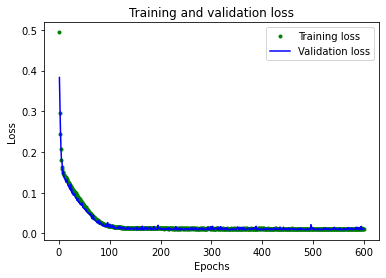

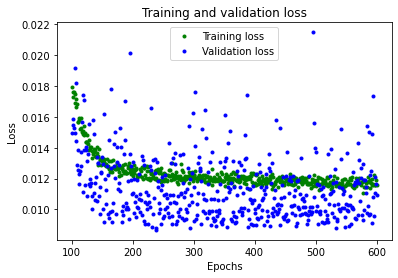

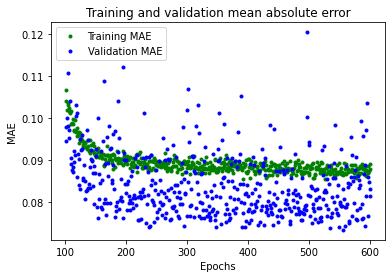

In [14]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Great results! From these graphs, we can see several exciting things:

*   Our network has reached its peak accuracy much more quickly (within 200 epochs instead of 600)
*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


200/200 [==============================] - 0s 149us/sample - loss: 0.0118 - mae: 0.0889


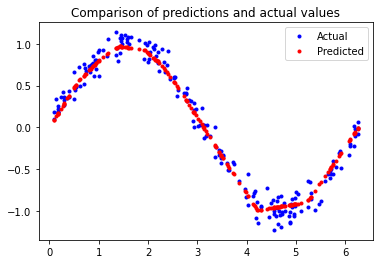

In [15]:
# Calculate and print the loss on our test dataset
loss = model_2.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model_2.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 4.2 and 5.2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.

However, an important part of machine learning is knowing when to quit, and this model is good enough for our use case - which is to make some LEDs blink in a pleasing pattern.

## Convert to TensorFlow Lite
We now have an acceptably accurate model in-memory. However, to use this with TensorFlow Lite for Microcontrollers, we'll need to convert it into the correct format and download it as a file. To do this, we'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert). The converter outputs a file in a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of models is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

The TensorFlow Lite Converter can apply quantization while it converts the model. In the following cell, we'll convert the model twice: once with quantization, once without:

In [16]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# Save the model to disk
open("sine_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("sine_model_quantized.tflite", "wb").write(tflite_model)

2720

## Test the converted models
To prove these models are still accurate after conversion and quantization, we'll use both of them to make predictions and compare these against our test results:

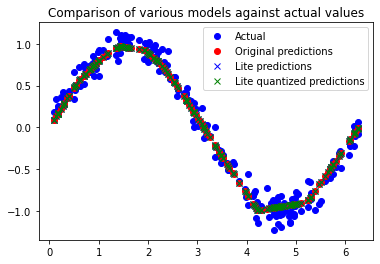

In [17]:
# Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
sine_model_input = sine_model.tensor(sine_model.get_input_details()[0]["index"])
sine_model_output = sine_model.tensor(sine_model.get_output_details()[0]["index"])
sine_model_quantized_input = sine_model_quantized.tensor(sine_model_quantized.get_input_details()[0]["index"])
sine_model_quantized_output = sine_model_quantized.tensor(sine_model_quantized.get_output_details()[0]["index"])

# Create arrays to store the results
sine_model_predictions = np.empty(x_test.size)
sine_model_quantized_predictions = np.empty(x_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(x_test.size):
  sine_model_input().fill(x_test[i])
  sine_model.invoke()
  sine_model_predictions[i] = sine_model_output()[0]

  sine_model_quantized_input().fill(x_test[i])
  sine_model_quantized.invoke()
  sine_model_quantized_predictions[i] = sine_model_quantized_output()[0]

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()


We can see from the graph that the predictions for the original model, the converted model, and the quantized model are all close enough to be indistinguishable. This means that our quantized model is ready to use!

We can print the difference in file size:

In [18]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 2732 bytes
Quantized model is 2720 bytes
Difference is 12 bytes


Our quantized model is only 16 bytes smaller than the original version, which only a tiny reduction in size! At around 2.6 kilobytes, this model is already so small that the weights make up only a small fraction of the overall size, meaning quantization has little effect.

More complex models have many more weights, meaning the space saving from quantization will be much higher, approaching 4x for most sophisticated models.

Regardless, our quantized model will take less time to execute than the original version, which is important on a tiny microcontroller!

## Write to a C file
The final step in preparing our model for use with TensorFlow Lite for Microcontrollers is to convert it into a C source file. You can see an example of this format in [`hello_world/sine_model_data.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/sine_model_data.cc).

To do so, we can use a command line utility named [`xxd`](https://linux.die.net/man/1/xxd). The following cell runs `xxd` on our quantized model and prints the output:

In [19]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
# Print the source file
!cat sine_model_quantized.cc

'apt-get'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'xxd'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'cat'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


We can either copy and paste this output into our project's source code, or download the file using the collapsible menu on the left hand side of this Colab.

